In [2]:
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

In [3]:
import numpy as np
import pyNN.nest as sim
from quantities import uS


params = { 'cm': 1., # nF
         'vrest': -70., # mV
         'ereve':  20., # mV
         'erevi': -80., # mV
         'w_e': .005, # uS
         'w_i': .05, # uS
         'taum': 20., # ms
         'tausyne': 2., # ms
         'tausyni': 5., # ms
         'taur': 2., # ms
         'v_thresh': 21. # mV
     }

ratee = 10000. # Hz
ratei = 3820.

tsim = 500.
dt = .1
t = np.arange(0,tsim+dt,dt)

def simulate_cond(params, ratee, ratei):

    sim.setup(timestep=dt, min_delay=dt, max_delay=dt)

    # Hint: The CUBA neuron is called IF_curr_exp
    
    ifcellscond = sim.create(sim.IF_cond_exp, {'cm'         : params['cm'],
                                                'tau_m'      : params['taum'],
                                                'tau_syn_E'  : params['tausyne'],
                                                'tau_syn_I'  : params['tausyni'],
                                                'e_rev_E'    : params['ereve'],
                                                'e_rev_I'    : params['erevi'],
                                                'v_rest'     : params['vrest'],
                                                'v_thresh'   : params['v_thresh'],
                                                'tau_refrac' : params['taur']})

    ifcellscond.initialize(v=-70.)

    spikesource3E = sim.create(sim.SpikeSourcePoisson,
                               {'duration':tsim, 'start':0., 'rate':ratee})
    spikesource3I = sim.create(sim.SpikeSourcePoisson,
                               {'duration':tsim, 'start':0., 'rate':ratei})


    sim.connect(spikesource3E, ifcellscond, weight=params['w_e'],
                receptor_type='excitatory', delay=0.1)
    sim.connect(spikesource3I, ifcellscond, weight=params['w_i'],
                receptor_type='inhibitory', delay=0.1)


    ifcellscond.record(['v','gsyn_exc', 'gsyn_inh'])

    sim.run(tsim)

    vcond = np.array(ifcellscond.get_v().segments[0].analogsignalarrays[0]).T[0]
    
    g = ifcellscond.get_data()
    g_exc = np.array(g.segments[0].analogsignalarrays[0].T[0])
    g_inh = np.array(g.segments[0].analogsignalarrays[1].T[0])

    sim.end()

    return vcond, g_exc, g_inh

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


## Part a)
Start with finding the $\nu_i$ such that the mean of the output is close to the rev. Potential:

In [4]:
vmin = 10000
for ratei in np.linspace(3800,3850,100):
    vcond, g_exc, g_inh = simulate_cond(params, ratee, ratei)
    if abs(np.mean(vcond)+70)< vmin:
        vmin = np.mean(vcond)+70
        vcond_min = vcond
        g_exc_min = g_exc
        g_inh_min = g_inh
        rate_min = ratei

/wang/environment/software/jessie/nest/2.8.0_nomusic+nompi+openmp/lib/python2.7/site-packages/nest/hl_api.py:85: UserWarning: 
ConvergentConnect is deprecated and will be removed in a future version of NEST.
Please use Connect instead!
For details, see http://www.nest-simulator.org/connection_management                       


3802.02020202


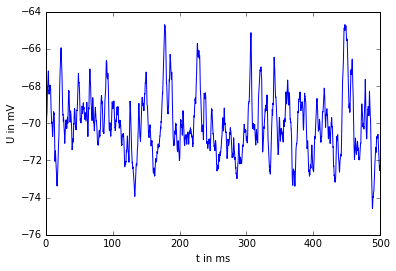

In [5]:
plt.plot(t,vcond_min)
plt.xlabel('t in ms')
plt.ylabel('U in mV')
print(rate_min)

## Part b)

In [6]:
tau_eff = params['cm']/ (params['cm']/params['taum']+np.mean(g_exc_min)+np.mean(g_inh_min))
print(tau_eff)

0.898953701709


Consider 
$I_\text{syn}^\text{CUBA} \simeq I_\text{syn}^\text{COBA}$

, therefore 

$ w_\text{e/i}^\text{COBA}\cdot (E_\text{e/i}-U) \simeq w_\text{e/i}^\text{CUBA}$.

We get:

$w_\text{e}^\text{CUBA}=w_\text{e}^\text{COBA}\cdot 90 mV = 450 nS$

$w_\text{i}^\text{CUBA}=w_\text{i}^\text{COBA}\cdot -10 mV = -500 nS$


In [7]:
params = { 'cm': 1., # nF
         'vrest': -70., # mV
         'ereve':  20., # mV
         'erevi': -80., # mV
         'w_e': .450, # uS
         'w_i': -.500, # uS
         'taum': tau_eff, # ms
         'tausyne': 2., # ms
         'tausyni': 5., # ms
         'taur': 2., # ms
         'v_thresh': 21. # mV
     }

ratee = 10000. # Hz
ratei = 3820.

tsim = 500.
dt = .1
t = np.arange(0,tsim+dt,dt)

def simulate_curr(params, ratee, ratei):

    sim.setup(timestep=dt, min_delay=dt, max_delay=dt)

    # Hint: The CUBA neuron is called IF_curr_exp
    #cm, i_offset, tau_m, tau_refrac, tau_syn_E, tau_syn_I, v_reset, v_rest, v_thresh
    ifcellscond = sim.create(sim.IF_curr_exp, {'cm'         : params['cm'],
                                                'tau_m'      : params['taum'],
                                                'tau_syn_E'  : params['tausyne'],
                                                'tau_syn_I'  : params['tausyni'],
                                                'v_rest'     : params['vrest'],
                                                'v_thresh'   : params['v_thresh'],
                                                'tau_refrac' : params['taur']})

    ifcellscond.initialize(v=-70.)

    spikesource3E = sim.create(sim.SpikeSourcePoisson,
                               {'duration':tsim, 'start':0., 'rate':ratee})
    spikesource3I = sim.create(sim.SpikeSourcePoisson,
                               {'duration':tsim, 'start':0., 'rate':ratei})


    sim.connect(spikesource3E, ifcellscond, weight=params['w_e'],
                receptor_type='excitatory', delay=0.1)
    sim.connect(spikesource3I, ifcellscond, weight=params['w_i'],
                receptor_type='inhibitory', delay=0.1)


    ifcellscond.record(['v'])

    sim.run(tsim)

    vcurr = np.array(ifcellscond.get_v().segments[0].analogsignalarrays[0]).T[0]
    
    #g = ifcellscond.get_data()
    #g_exc = np.array(g.segments[0].analogsignalarrays[0].T[0])
    #g_inh = np.array(g.segments[0].analogsignalarrays[1].T[0])

    sim.end()

    return vcurr
vcurr = simulate_curr(params, ratee, ratei)

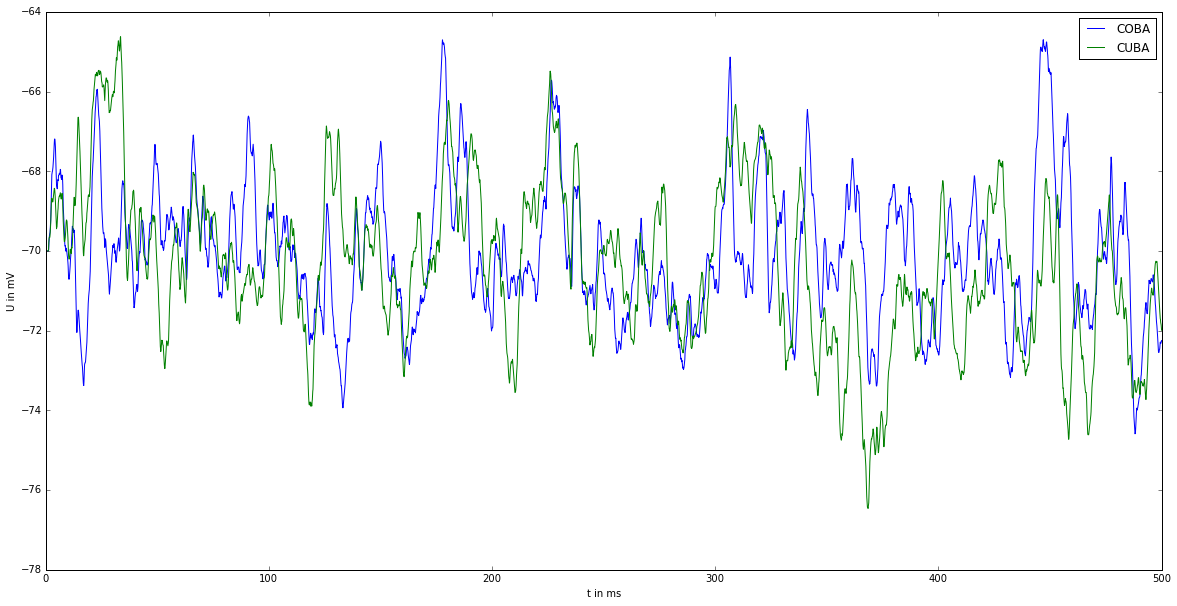

In [8]:
plt.figure(figsize=(20,10))
plt.plot(t,vcond_min, label = 'COBA')
plt.plot(t,vcurr, label = 'CUBA')
plt.xlabel('t in ms')
plt.ylabel('U in mV')
plt.legend()
plt.show()

## Part c)

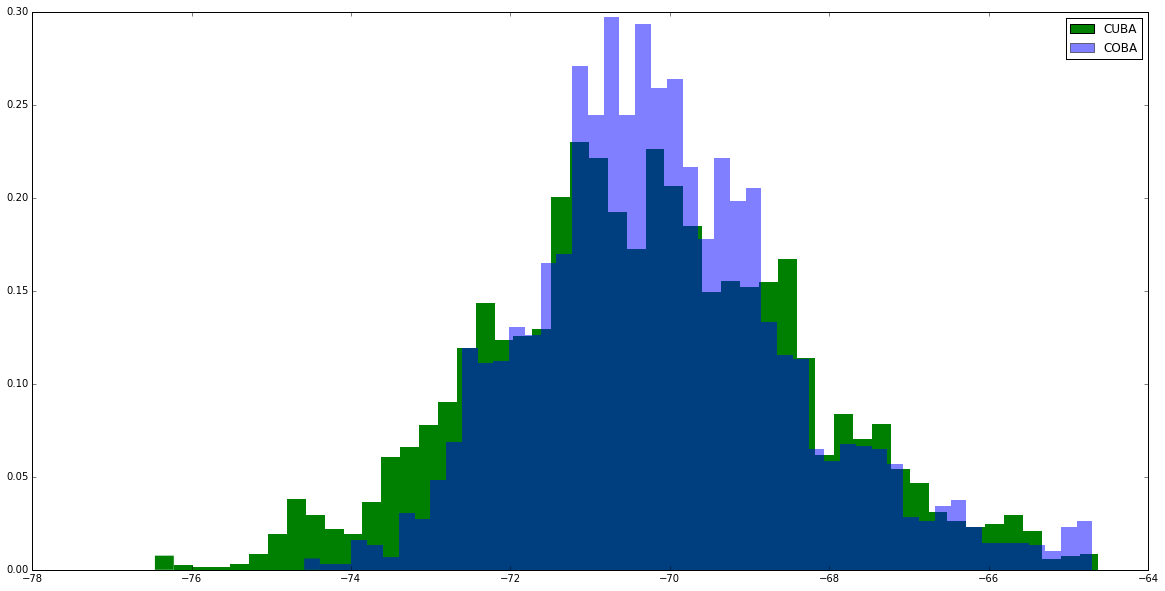

In [9]:
plt.figure(figsize=(20,10))
plt.hist(vcurr,50, normed=1, facecolor='green', alpha=1,edgecolor = "none", label = 'CUBA')
plt.hist(vcond_min,50, normed=1, facecolor='blue', alpha=0.5,edgecolor = "none", label = 'COBA')
plt.legend()
plt.show()

## Part d)

In [10]:
vcond5, _,_ = simulate_cond(params, ratee*5, rate_min*5)
vcurr5 = simulate_curr(params, ratee*5, rate_min*5)

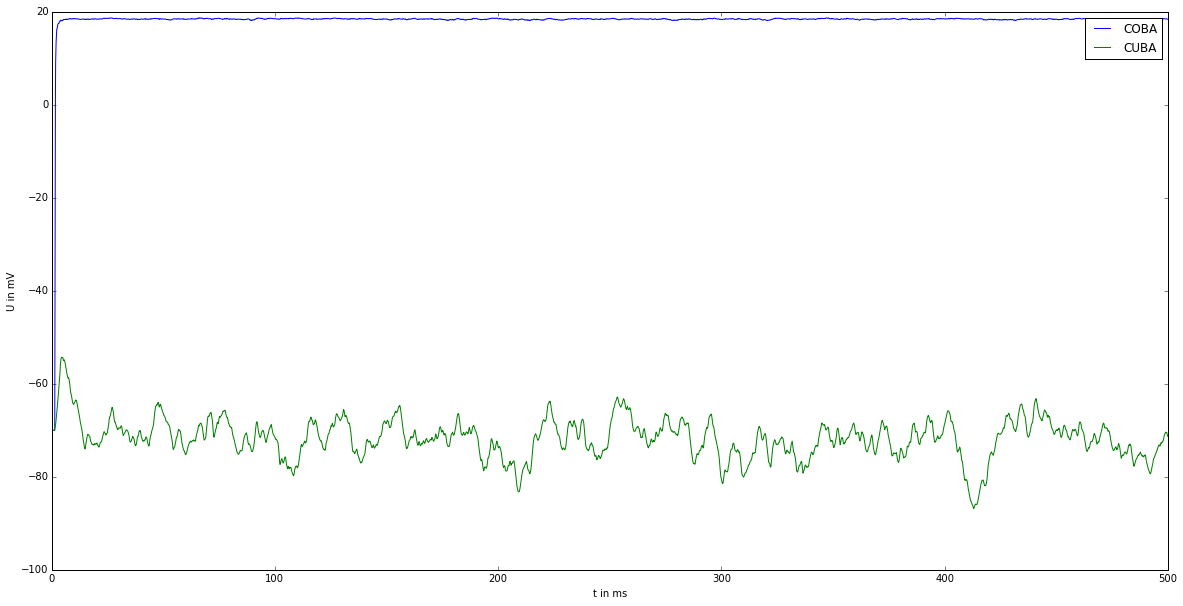

In [14]:
plt.figure(figsize=(20,10))
plt.plot(t,vcond5, label = 'COBA')
plt.plot(t,vcurr5, label = 'CUBA')
plt.xlabel('t in ms')
plt.ylabel('U in mV')
plt.legend()
plt.show()

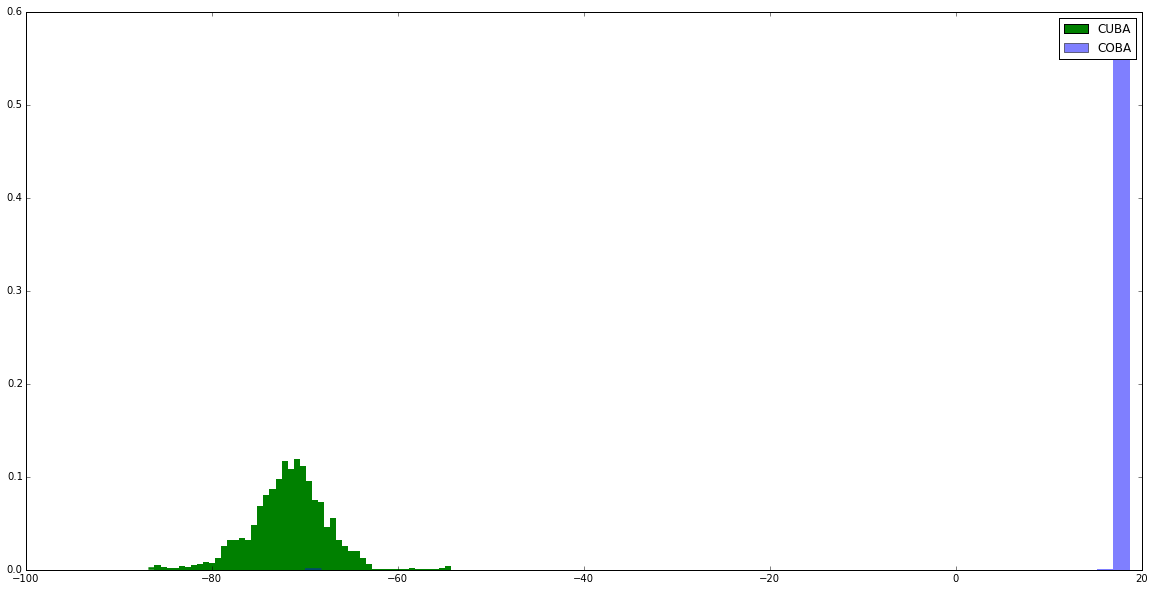

In [12]:
plt.figure(figsize=(20,10))
plt.hist(vcurr5,50, normed=1, facecolor='green', alpha=1,edgecolor = "none", label = 'CUBA')
plt.hist(vcond5,50, normed=1, facecolor='blue', alpha=0.5,edgecolor = "none", label = 'COBA')
plt.legend()
plt.show()